In [54]:
from environment.blackjack import Blackjack

In [55]:
env = Blackjack()

In [56]:
import torch
import torch.nn as nn

In [57]:
device = "cpu"
print(f"device: {device}")

device: cpu


In [58]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
        )

    def forward(self, x):
        x_norm = x.clone()
        x_norm[:, 0] = x[:, 0] / 21.0
        x_norm[:, 1] = x[:, 1] / 11.0
        logits = self.layers(x_norm)
        return logits

In [59]:
torch.manual_seed(11)
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (layers): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
  )
)


In [60]:
import random
from collections import deque
class ReplayBuffer():
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))


    def sample(self, batch_size):
        return random.sample(self.buffer, min(batch_size, len(self.buffer)))


    def size(self):
        return len(self.buffer)

In [61]:
buffer = ReplayBuffer(100000)

In [62]:
def get_action(state, epsilon, double_possible, splittable):
    if random.random() < epsilon:
        return env.action_random(double_possible, splittable)

    with torch.no_grad():
        q_values = model(state[:, :3])
        if not double_possible:
            q_values[:, 2] = -99.0
        if not splittable:
            q_values[:, 3] = -99.0

    return torch.argmax(q_values).item()

In [63]:
import torch.nn.functional as F
def training(target_model):
    batch = zip(*buffer.sample(batch_size))

    state, action, reward, next_state, done = batch

    state = torch.stack(state).to(device).squeeze(1)
    action = torch.tensor(action).long().unsqueeze(1).to(device)
    reward = torch.tensor(reward).float().unsqueeze(1).to(device)
    next_state = torch.stack(next_state).to(device).squeeze(1)
    done = torch.tensor(done).float().unsqueeze(1).to(device)

    output = model(state[:, :3])
    label = output.gather(dim=1, index=action)

    with torch.no_grad():
        online_q_vals = model(next_state[:, :3])
        target_q_vals = target_model(next_state[:, :3])

        action_split = (action[:] == 3) + 1.0
        target_q_vals *= action_split

        cannot_double = (next_state[:, -2] == 0)
        cannot_split = (next_state[:, -1] == 0)
        online_q_vals[cannot_double, 2] = -99.0
        online_q_vals[cannot_split, 3] = -99.0

        best_actions = torch.argmax(online_q_vals, dim=1).unsqueeze(1).int()
        future_move = target_q_vals.gather(dim=1, index=best_actions)
        prediction = reward + (1 - done) * gamma * future_move

    loss = F.mse_loss(label, prediction)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [64]:
import copy
net_rewards = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
epochs = 3000000
batch_size = 128
gamma = 1.0
epsilon = 1.0
target_model = copy.deepcopy(model)
model.train()
reward_sum = 0
for epoch in range(epochs):
    state, reward, done = env.next_hand()

    state = torch.tensor(state, device=device).float().unsqueeze(0)

    if epoch % 5000 == 0:
        target_model.load_state_dict(model.state_dict())

    while not done:
        double_possible = state[:, -2]
        splittable = state[:, -1]

        if epoch < 10000:
            action = env.action_random(double_possible, splittable)
        else:
            action = get_action(state, epsilon, double_possible, splittable)

        next_state, reward, hand_over = env.step(action)
        if len(next_state) == 2:
            next_state = next_state[0]
        next_state = torch.tensor(next_state, device=device).float().unsqueeze(0)

        done = hand_over or action == 3
        buffer.push(state, action, reward, next_state, hand_over)
        o_state = state
        state = next_state

    reward_sum += reward

    if epoch < 10000:
        continue

    loss = training(target_model)

    if epoch % 10000 == 0 and epoch != 0:
        print(f"epoch: {epoch} | reward net: {round(reward_sum)/10000}")
        net_rewards.append(reward_sum/10000)
        reward_sum = 0

    if epoch < 0.75 * epochs:
        epsilon = max(0.1, epsilon*(0.1**(1/(epochs/2))))
    else:
        epsilon = 0

epoch: 10000 | reward net: -0.3849
epoch: 20000 | reward net: -0.3858
epoch: 30000 | reward net: -0.3899
epoch: 40000 | reward net: -0.4018
epoch: 50000 | reward net: -0.3988
epoch: 60000 | reward net: -0.391
epoch: 70000 | reward net: -0.3718
epoch: 80000 | reward net: -0.3564
epoch: 90000 | reward net: -0.3417
epoch: 100000 | reward net: -0.3608
epoch: 110000 | reward net: -0.3452
epoch: 120000 | reward net: -0.35
epoch: 130000 | reward net: -0.3134
epoch: 140000 | reward net: -0.3122
epoch: 150000 | reward net: -0.337
epoch: 160000 | reward net: -0.3306
epoch: 170000 | reward net: -0.3115
epoch: 180000 | reward net: -0.3265
epoch: 190000 | reward net: -0.3244
epoch: 200000 | reward net: -0.3018
epoch: 210000 | reward net: -0.2954
epoch: 220000 | reward net: -0.2732
epoch: 230000 | reward net: -0.309
epoch: 240000 | reward net: -0.277
epoch: 250000 | reward net: -0.2626
epoch: 260000 | reward net: -0.2712
epoch: 270000 | reward net: -0.2782
epoch: 280000 | reward net: -0.28
epoch: 29

In [69]:
state = env.next_hand()
state = (11, 9, 0)
print(state)
state = torch.tensor(state, device=device).float().unsqueeze(0)
output = model(state)
print(output)
action = torch.argmax(output).item()

(11, 9, 0)
tensor([[-0.5431,  0.1243,  0.2034, -0.5785]], grad_fn=<AddmmBackward0>)


In [70]:
games = 100000
model.eval()
wins = 0
draws = 0
losses = 0
net_score = 0
for game in range(games):
    state, reward, done = env.next_hand()
    state = torch.tensor(state, device=device).float().unsqueeze(0)


    while not done:
        with torch.no_grad():
            q_values = model(state[:, :3])
            if state[0, -2] == 0:
                q_values[0, -2] = -99
            if state[0, -1] == 0:
                q_values[0, -1] = -99

            action = torch.argmax(q_values).item()

        if action == 3:
            _ = env.step(action)
            terminated = False
            next_state, reward, terminated = env.next_hand()


        else:
            next_state, reward, terminated = env.step(action)


        next_state = torch.tensor(next_state, device=device).float().unsqueeze(0)

        done = terminated

        state = next_state

    if reward > 0:
        wins += 1
    elif reward == 0:
        draws += 1
    else:
        losses += 1

    net_score += reward

print(f"Wins: {wins} | Draws: {draws} | Losses: {losses}")
print(f"Win Accuracy: {(wins/games)*100:.2f}% | Draw Accuracy: {(draws/games)*100:.2f}% | Loss Accuracy: {(losses/games)*100:.2f}%")
print(f"Net Score: {net_score/100000}")

Wins: 43925 | Draws: 8375 | Losses: 47700
Win Accuracy: 43.92% | Draw Accuracy: 8.38% | Loss Accuracy: 47.70%
Net Score: 0.00566


In [80]:
torch.save(model.state_dict(), "blackjack_model_weights.pth")

<function matplotlib.pyplot.show(close=None, block=None)>

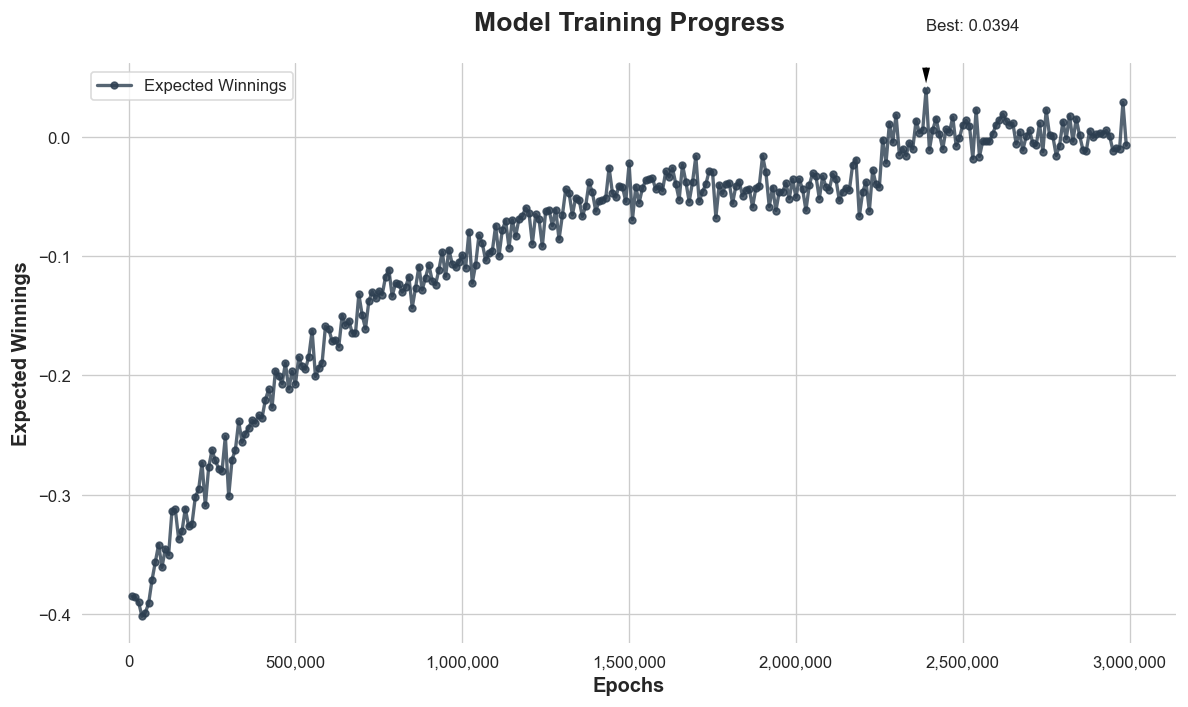

In [71]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6), dpi=120)

epochs = range(10000, 3000000, 10000)

plt.plot(epochs, net_rewards, "o-", color="#2c3e50", label="Expected Winnings", linewidth=2, markersize=4, alpha=0.8)

ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(200000))
ax.xaxis.get_major_formatter().set_scientific(False)
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

plt.title("Model Training Progress", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Epochs", fontsize=12, fontweight="semibold")
plt.ylabel("Expected Winnings", fontsize=12, fontweight="semibold")

plt.legend(frameon=True, facecolor="white", edgecolor="lightgray")

sns.despine(left=True, bottom=True)
max_reward = max(net_rewards)
max_epoch = epochs[net_rewards.index(max_reward)]
plt.annotate(f'Best: {max_reward:.4f}',
                 xy=(max_epoch, max_reward),
                 xytext=(max_epoch + 1, max_reward + 0.05),
                 arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6))



plt.tight_layout()
plt.show

In [72]:
import numpy as np
#Hard Hands
player_hands = range(5, 22)
dealer_hands = range(2, 12)

hard_hands = np.zeros((len(player_hands), len(dealer_hands)))

for h in range(len(player_hands)):
    for w in range(len(dealer_hands)):
        input = torch.tensor((player_hands[h], dealer_hands[w], 0), device=device).float().unsqueeze(0)
        q_values = model(input)
        q_values[0, -1] = -99
        action = torch.argmax(q_values).item()
        hard_hands[h, w] = action
print(hard_hands)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 2. 2. 2. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 1.]
 [1. 1. 0. 0. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [73]:
player_hands = range(13, 22)
dealer_hands = range(2, 12)

soft_hands = np.zeros((len(player_hands), len(dealer_hands)))

for h in range(len(player_hands)):
    for w in range(len(dealer_hands)):
        input = torch.tensor((player_hands[h], dealer_hands[w], 1), device=device).float().unsqueeze(0)
        q_values = model(input)
        q_values[0, -1] = -99
        action = torch.argmax(q_values).item()
        soft_hands[h, w] = action

print(soft_hands)

[[1. 2. 2. 2. 1. 1. 1. 1. 1. 1.]
 [1. 1. 2. 2. 1. 1. 1. 1. 1. 1.]
 [2. 2. 1. 2. 2. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [74]:
player_hands = range(4, 23, 2)
dealer_hands = range(2, 12)

splittable_hands = np.zeros((len(player_hands), len(dealer_hands)))

for h in range(len(player_hands)):
    for w in range(len(dealer_hands)):
        input = torch.tensor((player_hands[h], dealer_hands[w], 0), device=device).float().unsqueeze(0)
        if h == 9:
            input = torch.tensor((12, dealer_hands[w], 1), device=device).float().unsqueeze(0)
        q_values = model(input)
        action = torch.argmax(q_values).item()
        splittable_hands[h, w] = action

print(splittable_hands)

[[1. 1. 3. 3. 3. 3. 1. 1. 1. 1.]
 [1. 1. 3. 3. 3. 1. 1. 1. 1. 1.]
 [1. 3. 3. 3. 1. 1. 1. 1. 1. 1.]
 [2. 2. 2. 2. 2. 2. 2. 2. 1. 1.]
 [1. 3. 3. 3. 3. 1. 1. 1. 1. 1.]
 [3. 3. 3. 3. 3. 3. 3. 1. 1. 1.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 1.]
 [0. 0. 3. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]]


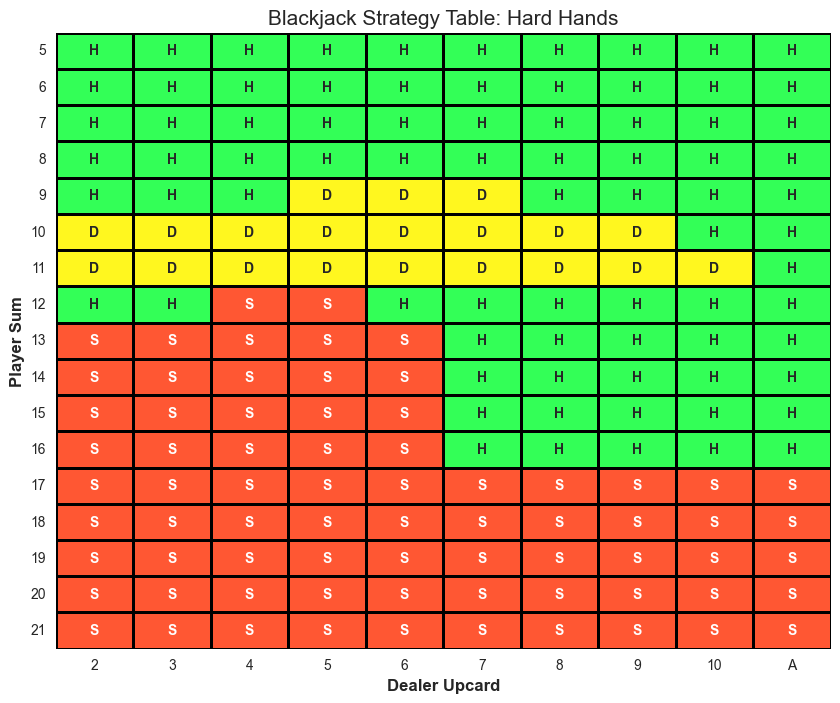

In [78]:
colors4 = ['#FF5733', '#33FF57', '#3357FF', '#FFF71F']
colors3 = ['#FF5733', '#33FF57', '#3357FF']
action_dic = {0: "S", 1: "H", 2: "D", 3: "P"}

plt.figure(figsize=(10, 8))
hard_map = sns.heatmap(hard_hands, annot=True, fmt="", cmap=colors3, cbar=False, linewidths=1, linecolor="black")
for text in hard_map.texts:
    value = int(float(text.get_text()))
    text.set_text(action_dic[value])
    text.set_weight("bold")

player_labels = [str(i) for i in range(5, 22)]
dealer_labels = [str(i) for i in range(2, 11)] + ["A"]

hard_map.set_xticklabels(dealer_labels)
hard_map.set_yticklabels(player_labels)

plt.xlabel("Dealer Upcard", fontsize=12, fontweight="bold")
plt.ylabel("Player Sum", fontsize=12, fontweight="bold")
plt.title("Blackjack Strategy Table: Hard Hands", fontsize=15)
plt.yticks(rotation=0)
plt.show()

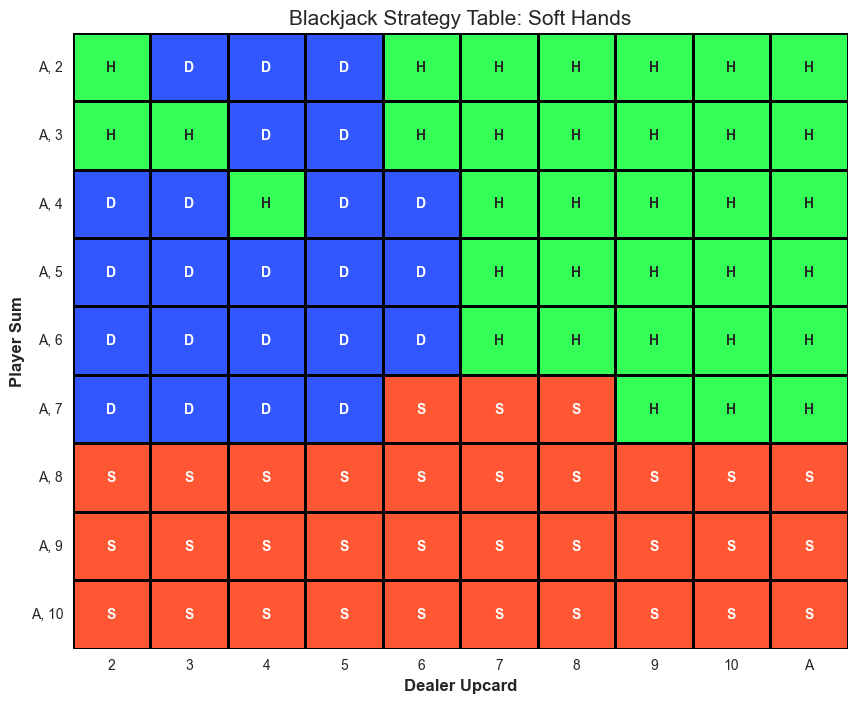

In [76]:
plt.figure(figsize=(10, 8))
soft_map = sns.heatmap(soft_hands, annot=True, fmt="", cmap=colors3, cbar=False, linewidths=1, linecolor="black")
for text in soft_map.texts:
    value = int(float(text.get_text()))
    text.set_text(action_dic[value])
    text.set_weight("bold")

player_labels = ["A, " + str(i) for i in range(2, 11)]
dealer_labels = [str(i) for i in range(2, 11)] + ["A"]

soft_map.set_xticklabels(dealer_labels)
soft_map.set_yticklabels(player_labels)

plt.xlabel("Dealer Upcard", fontsize=12, fontweight="bold")
plt.ylabel("Player Sum", fontsize=12, fontweight="bold")
plt.title("Blackjack Strategy Table: Soft Hands", fontsize=15)
plt.yticks(rotation=0)
plt.show()

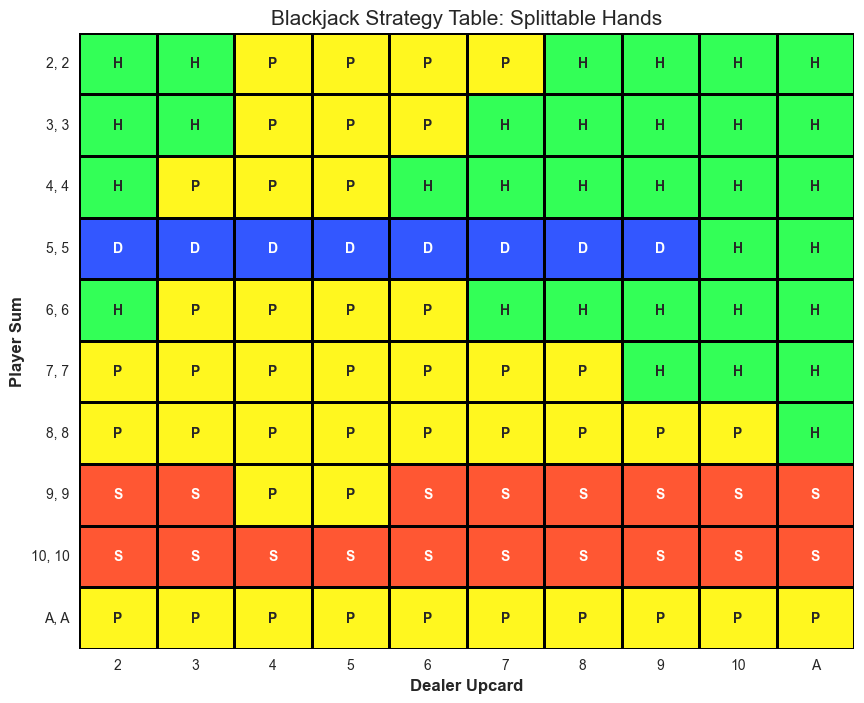

In [79]:
plt.figure(figsize=(10, 8))
split_map = sns.heatmap(splittable_hands, annot=True, fmt="", cmap=colors4, cbar=False, linewidths=1, linecolor="black")
for text in split_map.texts:
    value = int(float(text.get_text()))
    text.set_text(action_dic[value])
    text.set_weight("bold")

player_labels = [str(i)+", "+str(i) for i in range(2, 11)] + ["A, A"]
dealer_labels = [str(i) for i in range(2, 11)] + ["A"]

split_map.set_xticklabels(dealer_labels)
split_map.set_yticklabels(player_labels)

plt.xlabel("Dealer Upcard", fontsize=12, fontweight="bold")
plt.ylabel("Player Sum", fontsize=12, fontweight="bold")
plt.title("Blackjack Strategy Table: Splittable Hands", fontsize=15)
plt.yticks(rotation=0)
plt.show()
